In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def get_mask_imgs(img_path):
    mask_imgs = []
    for img in os.listdir(img_path):
        if img.split('.')[-1] == 'png':
            mask_imgs.append(img_path+"/"+img)
    return mask_imgs

def read_imgs(mask_path):
    mask_imgs = get_mask_imgs(mask_path) 
    # print(mask_imgs)
    masks = []
    for img in mask_imgs:
        mask = cv2.imread(img, 0)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        ret, bw_img = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
        # print(bw_img.shape)
        # plt.imshow(mask)    
        masks.append(bw_img)    
    return masks

def find_rectangle_manually(given_masks):
    rectangles = []
    for mask in given_masks:
        mask = np.array(mask)
        gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        # print(*gray_mask[400])
        row_ind = []
        for i in range(gray_mask.shape[0]):
            inds = np.where(gray_mask[i] == 255)[0]
            if inds.size != 0:
                row_ind.append(i)
        top, bottom = row_ind[0], row_ind[-1]
        
        col_ind = []
        for i in range(gray_mask.shape[1]):
            inds = np.where(gray_mask[:, i] == 255)[0]
            if inds.size != 0:
                col_ind.append(i)
        left, right = col_ind[0], col_ind[-1]

        rectangles.append([
            [left, top],
            [right, top],
            [right, bottom],
            [left, bottom]
        ])
    return rectangles

In [4]:
# erode = cv2.erode(mask, (5, 5), iterations = 10)
# plt.imshow(erode)

# morph = cv2.morphologyEx(mask, cv2.MORPH_OPEN, (5, 5), iterations=10)
# plt.imshow(morph)

# dil = cv2.dilate(erode, (5,5), iterations = 10)
# plt.imshow(dil)

In [91]:
from rdp import rdp
def find_peak_points(mask):
    msk = mask.copy()
    edge=cv2.Canny(msk, 30, 20)
    contours, hierarchy = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    ## separating the mask outline from all other unwanted contours
    outline = contours[0]
    for i in contours[1:]:
        if outline.shape[0] < i.shape[0]:
            outline = i
    # print(outline.shape)
    
    msk = cv2.drawContours(msk, outline, -1, (0, 255, 0), 3)
    ## finding the peak points using the Douglas-Peucker algorithm
    pp=rdp(outline, epsilon=75)
    for i in pp:
        msk = cv2.circle(msk, i[0], 5, (0, 0, 255), -1)
    plt.imshow(msk)
    return pp
    
def pick_peak_pts(mask, pp):
    rect = find_rectangle_manually([mask])[0]
    new_rect = []
    for p1 in rect:
        pt_dist = []
        for p2 in pp:
            dist = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
            pt_dist = np.append(pt_dist, dist)
        # print(pt_dist)
        new_rect.append(pp[np.argmin(pt_dist)])
    
    tmp = mask.copy()
    for i in pp:
        tmp = cv2.circle(tmp, i, 8, (0, 0, 255), -1)
    for i in range(4):
        tmp = cv2.circle(tmp, rect[i], 5, (255, 0, 0), -1)
        tmp = cv2.circle(tmp, new_rect[i], 5, (0, 255, 0), -1)
    plt.imshow(tmp)
    
    return rect, new_rect

In [92]:
USER_IMG = 'img8'

all_mask_paths = "../inputs/masks/{}".format(USER_IMG)
all_masks = read_imgs(all_mask_paths)
print(len(all_masks))

4


6


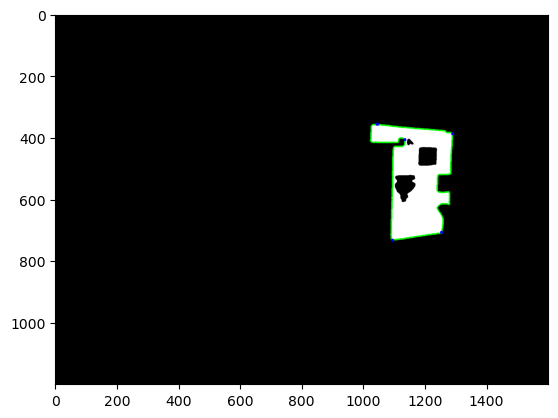

In [99]:
mask = all_masks[3]
peak_pts = find_peak_points(mask).reshape([-1, 2])
print(len(peak_pts))

[array([1045,  357], dtype=int32),
 array([1290,  388], dtype=int32),
 array([1254,  708], dtype=int32),
 array([1095,  733], dtype=int32)]

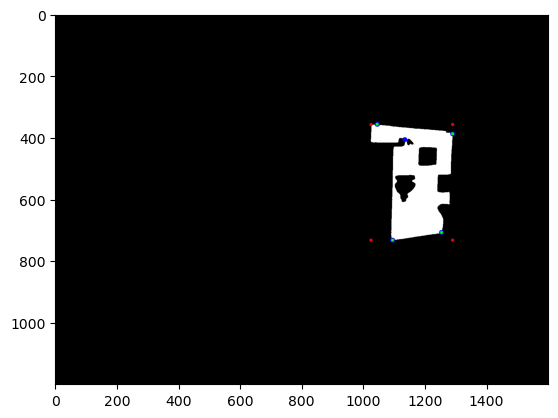

In [100]:
rect, new_rect = pick_peak_pts(mask, peak_pts)
new_rect